<h1><center>The Battle of the Neighborhoods!</center></h1>

### Applied Data Science Capstone by IBM/Coursera

## Introduction

Moving to another country is a diffucult task. Trying to discorver where to live, where is safe and have all to offer is no simple task.
Imagine that a company is moving to another country to make a new company headquarters and many of the employers are moving with. How can we simplify the search?  

First lets define what we are considering a good neighhood:  
  
- Safe place
- Enough atributes of interest for each one (Type of restaurants, Parks and other)

## Data

Based on definition of our problem, factors that will influence our decision are:  

- The total number of crimes commited in each of the borough during the last year.  
- The most common venues in each of the neighborhood in the safest borough selected.  

Following data sources will be needed to extract/generate the required information:  

- crimes table: http://data.torontopolice.on.ca/datasets/robbery-2014-to-2018  
- Toronto Neighborhoods:https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

## Import libraries 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # 
import folium # map rendering library

#Lib for html handling
from lxml import html

import requests
from bs4 import BeautifulSoup
import pandas as pd

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

<a id="#methodology"></a>

In [2]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [3]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)  
map_toronto

# Crimes in toronto

the first part of the work is to look at the most perilous neighborhoods in toronto so we will use the crime table https://opendata.arcgis.com/datasets/d888b0ed52864bd6ace51888322fda58_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D and transform it to better serve the purpose.  

We are only interesting in more recent crimes so we are only looking from crimes in 2018


In [4]:
crimes_toronto = pd.read_csv('https://opendata.arcgis.com/datasets/d888b0ed52864bd6ace51888322fda58_0.csv?outSR=%7B%22latestWkid%22%3A3857%2C%22wkid%22%3A102100%7D')

df_ct = crimes_toronto [['X', 'Y', 'reportedyear', 'offence', 'MCI', 'Neighbourhood', 'Lat', 'Long']]

df_ct.drop(df_ct.index[df_ct['reportedyear'] != 2018], inplace = True)
df_ct.head()

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,X,Y,reportedyear,offence,MCI,Neighbourhood,Lat,Long
2131,-79.389244,43.759922,2018,Robbery - Business,Robbery,St.Andrew-Windfields (40),43.759922,-79.389244
2208,-79.268257,43.767086,2018,Robbery - Purse Snatch,Robbery,Bendale (127),43.767086,-79.268257
2210,-79.305984,43.799000,2018,Robbery - Home Invasion,Robbery,L'Amoreaux (117),43.799000,-79.305984
2212,-79.417221,43.726246,2018,Robbery - Armoured Car,Robbery,Bedford Park-Nortown (39),43.726246,-79.417221
2214,-79.382401,43.650280,2018,Robbery - Home Invasion,Robbery,Bay Street Corridor (76),43.650280,-79.382401


In [5]:
df_ct_nh = df_ct.groupby(['Neighbourhood']).size().reset_index(name='Count')
df_ct_nh.head()

,Neighbourhood,Count
0,Agincourt North (129),47
1,Agincourt South-Malvern West (128),30
2,Alderwood (20),8
3,Annex (95),54
4,Banbury-Don Mills (42),7


## Toronto Neighbourhood with the Highest no. of crime

In [6]:
df_top5 = df_ct_nh.nlargest(5,['Count'])
df_top5

,Neighbourhood,Count
22,Church-Yonge Corridor (75),224
79,Moss Park (73),159
122,Waterfront Communities-The Island (77),93
138,York University Heights (27),85
62,Kensington-Chinatown (78),78


In [7]:
df_top5_plot = df_top5[['Neighbourhood','Count']]
df_top5_plot.set_index(['Neighbourhood'], inplace=True)
df_top5_plot

,Count
Neighbourhood,
Church-Yonge Corridor (75),224
Moss Park (73),159
Waterfront Communities-The Island (77),93
York University Heights (27),85
Kensington-Chinatown (78),78


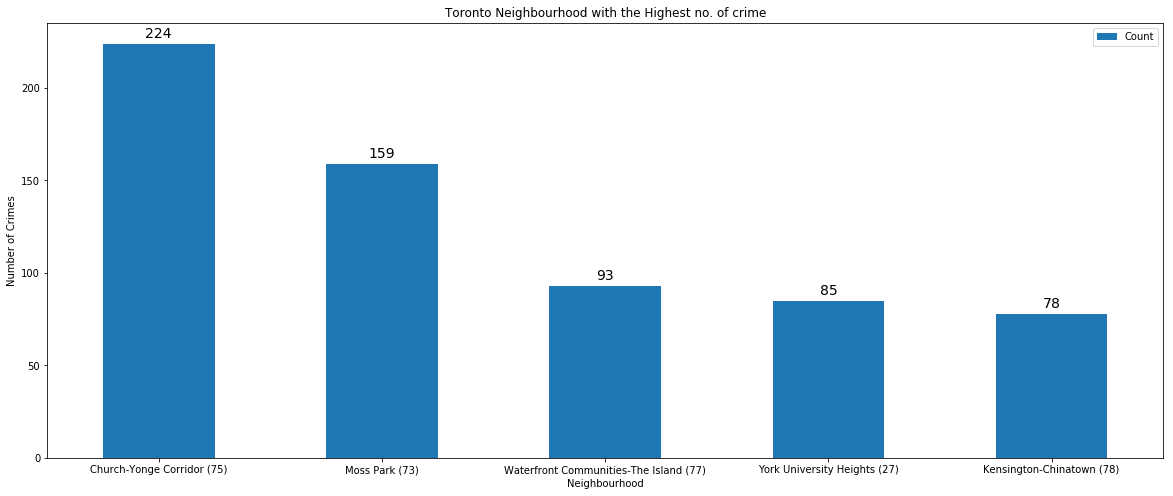

In [8]:
ax = df_top5_plot.plot(kind='bar', figsize=(20, 8), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighbourhood') # add y-label to the plot
ax.set_title('Toronto Neighbourhood with the Highest no. of crime') # add title to the plot

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Toronto Neighbourhood with the lowest no. of crime

In [9]:
df_low5 = df_ct_nh.nsmallest(5,['Count'])

df_low5_plot = df_low5[['Neighbourhood','Count']]
df_low5_plot.set_index(['Neighbourhood'], inplace=True)
df_low5_plot

,Count
Neighbourhood,
Eringate-Centennial_West Deane (11),1
Humewood-Cedarvale (106),1
Lambton Baby Point (114),1
Yonge-St.Clair (97),1
Lawrence Park North (105),2


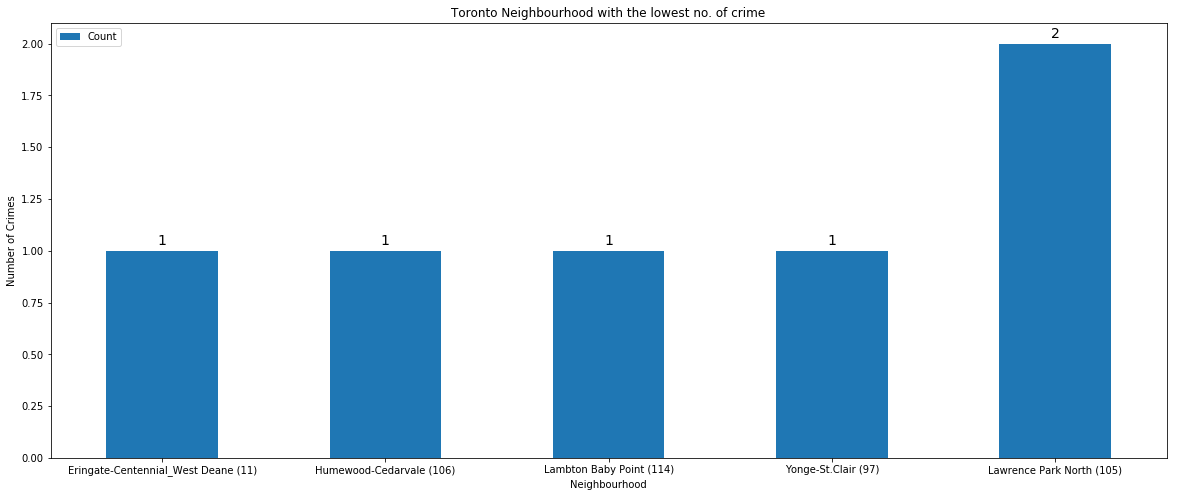

In [10]:
ax = df_low5_plot.plot(kind='bar', figsize=(20, 8), rot=0)

ax.set_ylabel('Number of Crimes') # add to x-label to the plot
ax.set_xlabel('Neighbourhood') # add y-label to the plot
ax.set_title('Toronto Neighbourhood with the lowest no. of crime') # add title to the plot

for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Explore the Borough with lowest crimes rates

Looking from the data colect in the crime dataframe it is possible to find 3 neighbouhoods with lowest crime rate.  
To be easy lets look to the first 2 neighbouhoods:  
  
- Eringate Centennial West Deane
- Humewood Cedarvale 
  
First let's find out what Borough they are part of

### Import Borough data

In [11]:
website_text = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(website_text,'xml')
table = soup.find('table',{'class':'wikitable sortable'})
table_rows = table.find_all('tr')
data = []
for row in table_rows:
    td=[]
    for t in row.find_all('td'):
        td.append(t.text.strip())
    data.append(td)
df = pd.DataFrame(data, columns=['PostalCode', 'Borough', 'Neighborhood'])
df = df[~df['Borough'].isnull()]
df.drop(df[df.Borough == 'Not assigned'].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(lambda x: ','.join(x)).reset_index()
df['Neighborhood'].replace('Not assigned',df['Borough'],inplace=True)
df.head(10)

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [12]:
df.tail(10)

,PostalCode,Borough,Neighborhood
93,M9A,Queen's Park,Queen's Park
94,M9B,Etobicoke,"Cloverdale,Islington,Martin Grove,Princess Gar..."
95,M9C,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B..."
96,M9L,North York,Humber Summit
97,M9M,North York,"Emery,Humberlea"
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie..."
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."
102,M9W,Etobicoke,Northwest


In [13]:
df[df['Neighborhood'].str.contains("Eringate")]

,PostalCode,Borough,Neighborhood
95,M9C,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B..."


It's possible to see that Eringate is part of the Etobicoke borough. Let's find out all of the neighborhood in Etobicoke.

In [14]:
df.loc[df['Borough'] == 'Etobicoke']

,PostalCode,Borough,Neighborhood
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto"
89,M8W,Etobicoke,"Alderwood,Long Branch"
90,M8X,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North"
91,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout..."
92,M8Z,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw..."
94,M9B,Etobicoke,"Cloverdale,Islington,Martin Grove,Princess Gar..."
95,M9C,Etobicoke,"Bloordale Gardens,Eringate,Markland Wood,Old B..."
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village,Martin Grove Gardens,Richvie..."
101,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam..."


Let's repeat the process for Humewood

In [15]:
df[df['Neighborhood'].str.contains("Humewood")]

,PostalCode,Borough,Neighborhood
73,M6C,York,Humewood-Cedarvale


In [16]:
df.loc[df['Borough'] == 'York']

,PostalCode,Borough,Neighborhood
73,M6C,York,Humewood-Cedarvale
74,M6E,York,Caledonia-Fairbanks
80,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn"
81,M6N,York,"The Junction North,Runnymede"
98,M9N,York,Weston


In [17]:
df_geo_coordinate = pd.read_csv('http://cocl.us/Geospatial_data')
df_geo_coordinate.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [18]:
df_geo_coordinate.rename(columns={'Postal Code':'PostalCode'},inplace=True)

In [19]:
df_merged_safest = df[df['Borough'].isin(['Etobicoke','York']) ]
df_merged_safest

,PostalCode,Borough,Neighborhood
73,M6C,York,Humewood-Cedarvale
74,M6E,York,Caledonia-Fairbanks
80,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn"
81,M6N,York,"The Junction North,Runnymede"
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto"
89,M8W,Etobicoke,"Alderwood,Long Branch"
90,M8X,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North"
91,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout..."
92,M8Z,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw..."
94,M9B,Etobicoke,"Cloverdale,Islington,Martin Grove,Princess Gar..."


In [20]:
df_merged = df_merged_safest.join(df_geo_coordinate.set_index('PostalCode'), on='PostalCode')
df_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
73,M6C,York,Humewood-Cedarvale,43.693781,-79.428191
74,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
80,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",43.691116,-79.476013
81,M6N,York,"The Junction North,Runnymede",43.673185,-79.487262
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321


In [21]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_merged['Latitude'], df_merged['Longitude'], df_merged['Borough'], df_merged['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=20,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.1,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

# Explore and cluster the neighborhoods in Toronto

In [22]:
CLIENT_ID = 'LWEMSXRGDOOQCS1RH5R1JAE4SMGHOKCVBDFQNI3WI3HGLEPM' # your Foursquare ID
CLIENT_SECRET = 'T4K5GPGSLXYGMOQ0FN4S10AVMKKABYLQPW3XM4YMW0HPCYCM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LWEMSXRGDOOQCS1RH5R1JAE4SMGHOKCVBDFQNI3WI3HGLEPM
CLIENT_SECRET:T4K5GPGSLXYGMOQ0FN4S10AVMKKABYLQPW3XM4YMW0HPCYCM


## 1 - Etobicoke

In [23]:
address = 'Etobicoke, ON'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Scarborough are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Scarborough are 43.67145915, -79.5524920661167.


In [24]:
LIMIT = 100

radius = 500 

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=LWEMSXRGDOOQCS1RH5R1JAE4SMGHOKCVBDFQNI3WI3HGLEPM&client_secret=T4K5GPGSLXYGMOQ0FN4S10AVMKKABYLQPW3XM4YMW0HPCYCM&v=20180605&ll=43.67145915,-79.5524920661167&radius=500&limit=100'

In [25]:
results = requests.get(url).json()

In [26]:
toronto_data = df_merged[df_merged['Borough'] == 'Etobicoke'].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321
1,M8W,Etobicoke,"Alderwood,Long Branch",43.602414,-79.543484
2,M8X,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North",43.653654,-79.506944
3,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509
4,M8Z,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw...",43.628841,-79.520999


In [27]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [28]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Metro,Supermarket,43.675011,-79.556234
1,Starbucks,Coffee Shop,43.674358,-79.555189
2,Shoppers Drug Mart,Pharmacy,43.674209,-79.555424
3,The Garden,Garden,43.671618,-79.553836
4,Lloyd Manor Park,Playground,43.672486,-79.554382


In [29]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [30]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Humber Bay Shores,Mimico South,New Toronto
Alderwood,Long Branch
The Kingsway,Montgomery Road,Old Mill North
Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea
Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor
Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park
Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe
Westmount
Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips
Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown
Northwest


In [31]:
print(toronto_venues.shape)
toronto_venues.head()

(66, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,LCBO,43.602281,-79.499302,Liquor Store
1,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,Domino's Pizza,43.601676,-79.500908,Pizza Place
2,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,New Toronto Fish & Chips,43.601849,-79.503281,Restaurant
3,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,Delicia Bakery & Pastry,43.601403,-79.503012,Bakery
4,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,Lucky Dice Restaurant,43.601392,-79.503056,Café


In [32]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown",7,7,7,7,7,7
"Alderwood,Long Branch",10,10,10,10,10,10
"Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe",8,8,8,8,8,8
"Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park",1,1,1,1,1,1
"Humber Bay Shores,Mimico South,New Toronto",11,11,11,11,11,11
"Humber Bay,King's Mill Park,Kingsway Park South East,Mimico NE,Old Mill South,The Queensway East,Royal York South East,Sunnylea",2,2,2,2,2,2
"Kingsview Village,Martin Grove Gardens,Richview Gardens,St. Phillips",3,3,3,3,3,3
"Kingsway Park South West,Mimico NW,The Queensway West,Royal York South West,South of Bloor",13,13,13,13,13,13
Northwest,2,2,2,2,2,2


In [33]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 38 uniques categories.


In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,American Restaurant,Athletics & Sports,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Filipino Restaurant,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Liquor Store,Locksmith,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Skating Rink,Supplement Shop,Tanning Salon,Wings Joint
0,"Humber Bay Shores,Mimico South,New Toronto",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Humber Bay Shores,Mimico South,New Toronto",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"Humber Bay Shores,Mimico South,New Toronto",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,"Humber Bay Shores,Mimico South,New Toronto",0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Humber Bay Shores,Mimico South,New Toronto",0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [35]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,American Restaurant,Athletics & Sports,Bakery,Baseball Field,Beer Store,Burger Joint,Burrito Place,Café,Chinese Restaurant,Coffee Shop,Convenience Store,Discount Store,Drugstore,Fast Food Restaurant,Filipino Restaurant,Fried Chicken Joint,Grocery Store,Gym,Hardware Store,Intersection,Liquor Store,Locksmith,Middle Eastern Restaurant,Mobile Phone Shop,Park,Pet Store,Pharmacy,Pizza Place,Pool,Pub,Rental Car Location,Restaurant,River,Sandwich Place,Skating Rink,Supplement Shop,Tanning Salon,Wings Joint
0,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.0,0.000000,0.0,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.142857,0.0,0.142857,0.142857,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.142857,0.142857,0.0,0.0,0.0,0.000000,0.0,0.142857,0.0,0.000000,0.000000,0.000000
1,"Alderwood,Long Branch",0.000000,0.1,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.100000,0.200000,0.1,0.1,0.0,0.000000,0.0,0.100000,0.1,0.000000,0.000000,0.000000
2,"Bloordale Gardens,Eringate,Markland Wood,Old B...",0.000000,0.0,0.000000,0.0,0.125000,0.000000,0.000000,0.125000,0.000000,0.125000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.0,0.000000,0.000000,0.125000,0.125,0.125000,0.125000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
3,"Cloverdale,Islington,Martin Grove,Princess Gar...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
4,"Humber Bay Shores,Mimico South,New Toronto",0.090909,0.0,0.090909,0.0,0.000000,0.000000,0.000000,0.090909,0.000000,0.000000,0.000000,0.000000,0.0,0.090909,0.0,0.090909,0.000000,0.090909,0.000000,0.000000,0.090909,0.0,0.000000,0.000000,0.000000,0.000,0.090909,0.090909,0.0,0.0,0.0,0.090909,0.0,0.090909,0.0,0.000000,0.000000,0.000000
5,"Humber Bay,King's Mill Park,Kingsway Park Sout...",0.000000,0.0,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
6,"Kingsview Village,Martin Grove Gardens,Richvie...",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.333333,0.333333,0.000,0.000000,0.333333,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
7,"Kingsway Park South West,Mimico NW,The Queensw...",0.000000,0.0,0.076923,0.0,0.000000,0.076923,0.076923,0.000000,0.000000,0.000000,0.076923,0.076923,0.0,0.076923,0.0,0.000000,0.076923,0.076923,0.076923,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.076923,0.0,0.076923,0.076923,0.076923
8,Northwest,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.0,0.5,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
9,"The Kingsway,Montgomery Road,Old Mill North",0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.500000,0.000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.5,0.000000,0.0,0.000000,0.000000,0.000000


In [36]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
                 venue  freq
0          Pizza Place  0.14
1           Beer Store  0.14
2       Sandwich Place  0.14
3        Grocery Store  0.14
4  Fried Chicken Joint  0.14


----Alderwood,Long Branch----
         venue  freq
0  Pizza Place   0.2
1          Pub   0.1
2  Coffee Shop   0.1
3          Gym   0.1
4     Pharmacy   0.1


----Bloordale Gardens,Eringate,Markland Wood,Old Burnhamthorpe----
          venue  freq
0  Liquor Store  0.12
1    Beer Store  0.12
2          Park  0.12
3     Pet Store  0.12
4          Café  0.12


----Cloverdale,Islington,Martin Grove,Princess Gardens,West Deane Park----
                       venue  freq
0        Filipino Restaurant   1.0
1        American Restaurant   0.0
2                       Pool   0.0
3  Middle Eastern Restaurant   0.0
4          Mobile Phone Shop   0.0


----Humber Bay Shores,Mimico South,New Toronto----
                

In [37]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Pizza Place,Beer Store,Fast Food Restaurant,Pharmacy,Grocery Store,Fried Chicken Joint,Sandwich Place,Baseball Field,Burger Joint,Burrito Place
1,"Alderwood,Long Branch",Pizza Place,Pharmacy,Athletics & Sports,Skating Rink,Sandwich Place,Gym,Pub,Pool,Coffee Shop,Café
2,"Bloordale Gardens,Eringate,Markland Wood,Old B...",Pizza Place,Pet Store,Liquor Store,Beer Store,Café,Coffee Shop,Park,Pharmacy,Fast Food Restaurant,Drugstore
3,"Cloverdale,Islington,Martin Grove,Princess Gar...",Filipino Restaurant,Wings Joint,Coffee Shop,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store,Chinese Restaurant
4,"Humber Bay Shores,Mimico South,New Toronto",American Restaurant,Pizza Place,Gym,Fast Food Restaurant,Liquor Store,Café,Fried Chicken Joint,Pharmacy,Restaurant,Sandwich Place


In [39]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 4, 4, 3, 4, 1, 0, 4, 2, 0], dtype=int32)

In [40]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321,4,American Restaurant,Pizza Place,Gym,Fast Food Restaurant,Liquor Store,Café,Fried Chicken Joint,Pharmacy,Restaurant,Sandwich Place
1,M8W,Etobicoke,"Alderwood,Long Branch",43.602414,-79.543484,4,Pizza Place,Pharmacy,Athletics & Sports,Skating Rink,Sandwich Place,Gym,Pub,Pool,Coffee Shop,Café
2,M8X,Etobicoke,"The Kingsway,Montgomery Road,Old Mill North",43.653654,-79.506944,0,River,Park,Wings Joint,Coffee Shop,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store
3,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509,1,Locksmith,Baseball Field,Wings Joint,Coffee Shop,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store
4,M8Z,Etobicoke,"Kingsway Park South West,Mimico NW,The Queensw...",43.628841,-79.520999,4,Wings Joint,Tanning Salon,Bakery,Burger Joint,Burrito Place,Convenience Store,Discount Store,Fast Food Restaurant,Grocery Store,Gym


In [41]:
toronto_merged=toronto_merged.dropna()

In [42]:
toronto_merged['Cluster Labels'] =toronto_merged['Cluster Labels'].astype(int)

In [43]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### **Cluster 1**

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Etobicoke,0,River,Park,Wings Joint,Coffee Shop,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store
8,Etobicoke,0,Pizza Place,Mobile Phone Shop,Park,Grocery Store,Filipino Restaurant,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store,Coffee Shop


#### **Cluster 2**

In [45]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Etobicoke,1,Locksmith,Baseball Field,Wings Joint,Coffee Shop,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store


#### **Cluster 3**

In [46]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Etobicoke,2,Drugstore,Rental Car Location,Wings Joint,Chinese Restaurant,Fried Chicken Joint,Filipino Restaurant,Fast Food Restaurant,Discount Store,Convenience Store,Coffee Shop


#### **Cluster 4**

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Etobicoke,3,Filipino Restaurant,Wings Joint,Coffee Shop,Grocery Store,Fried Chicken Joint,Fast Food Restaurant,Drugstore,Discount Store,Convenience Store,Chinese Restaurant


#### **Cluster 5**

In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etobicoke,4,American Restaurant,Pizza Place,Gym,Fast Food Restaurant,Liquor Store,Café,Fried Chicken Joint,Pharmacy,Restaurant,Sandwich Place
1,Etobicoke,4,Pizza Place,Pharmacy,Athletics & Sports,Skating Rink,Sandwich Place,Gym,Pub,Pool,Coffee Shop,Café
4,Etobicoke,4,Wings Joint,Tanning Salon,Bakery,Burger Joint,Burrito Place,Convenience Store,Discount Store,Fast Food Restaurant,Grocery Store,Gym
6,Etobicoke,4,Pizza Place,Pet Store,Liquor Store,Beer Store,Café,Coffee Shop,Park,Pharmacy,Fast Food Restaurant,Drugstore
7,Etobicoke,4,Pizza Place,Chinese Restaurant,Intersection,Sandwich Place,Middle Eastern Restaurant,Discount Store,Coffee Shop,Filipino Restaurant,Fast Food Restaurant,Drugstore
9,Etobicoke,4,Pizza Place,Beer Store,Fast Food Restaurant,Pharmacy,Grocery Store,Fried Chicken Joint,Sandwich Place,Baseball Field,Burger Joint,Burrito Place


## 1 - York

In [49]:
toronto_data = df_merged[df_merged['Borough'] == 'York'].reset_index(drop=True)
toronto_data.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M6C,York,Humewood-Cedarvale,43.693781,-79.428191
1,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512
2,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",43.691116,-79.476013
3,M6N,York,"The Junction North,Runnymede",43.673185,-79.487262
4,M9N,York,Weston,43.706876,-79.518188


In [50]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Metro,Supermarket,43.675011,-79.556234
1,Starbucks,Coffee Shop,43.674358,-79.555189
2,Shoppers Drug Mart,Pharmacy,43.674209,-79.555424
3,The Garden,Garden,43.671618,-79.553836
4,Lloyd Manor Park,Playground,43.672486,-79.554382


In [52]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [53]:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )

Humewood-Cedarvale
Caledonia-Fairbanks
Del Ray,Keelesdale,Mount Dennis,Silverthorn
The Junction North,Runnymede
Weston


In [54]:
print(toronto_venues.shape)
toronto_venues.head()

(18, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Park,43.692535,-79.428705,Field
1,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Tennis Courts,43.692744,-79.432244,Tennis Court
2,Humewood-Cedarvale,43.693781,-79.428191,Phil White Arena,43.691303,-79.431761,Hockey Arena
3,Humewood-Cedarvale,43.693781,-79.428191,Cedarvale Ravine,43.690188,-79.426106,Trail
4,Caledonia-Fairbanks,43.689026,-79.453512,KFC,43.690647,-79.456326,Fast Food Restaurant


In [55]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Caledonia-Fairbanks,5,5,5,5,5,5
"Del Ray,Keelesdale,Mount Dennis,Silverthorn",5,5,5,5,5,5
Humewood-Cedarvale,4,4,4,4,4,4
"The Junction North,Runnymede",4,4,4,4,4,4


In [56]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 15 uniques categories.


In [57]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Breakfast Spot,Bus Line,Check Cashing Service,Convenience Store,Discount Store,Fast Food Restaurant,Field,Grocery Store,Hockey Arena,Market,Park,Sandwich Place,Tennis Court,Trail,Women's Store
0,Humewood-Cedarvale,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Humewood-Cedarvale,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,Humewood-Cedarvale,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,Humewood-Cedarvale,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,Caledonia-Fairbanks,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [58]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Breakfast Spot,Bus Line,Check Cashing Service,Convenience Store,Discount Store,Fast Food Restaurant,Field,Grocery Store,Hockey Arena,Market,Park,Sandwich Place,Tennis Court,Trail,Women's Store
0,Caledonia-Fairbanks,0.00,0.00,0.0,0.00,0.0,0.2,0.00,0.00,0.00,0.2,0.4,0.0,0.00,0.00,0.2
1,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",0.00,0.00,0.2,0.00,0.2,0.4,0.00,0.00,0.00,0.0,0.0,0.2,0.00,0.00,0.0
2,Humewood-Cedarvale,0.00,0.00,0.0,0.00,0.0,0.0,0.25,0.00,0.25,0.0,0.0,0.0,0.25,0.25,0.0
3,"The Junction North,Runnymede",0.25,0.25,0.0,0.25,0.0,0.0,0.00,0.25,0.00,0.0,0.0,0.0,0.00,0.00,0.0


In [59]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Caledonia-Fairbanks----
                  venue  freq
0                  Park   0.4
1  Fast Food Restaurant   0.2
2                Market   0.2
3         Women's Store   0.2
4        Breakfast Spot   0.0


----Del Ray,Keelesdale,Mount Dennis,Silverthorn----
                   venue  freq
0   Fast Food Restaurant   0.4
1  Check Cashing Service   0.2
2         Discount Store   0.2
3         Sandwich Place   0.2
4         Breakfast Spot   0.0


----Humewood-Cedarvale----
            venue  freq
0           Field  0.25
1    Hockey Arena  0.25
2    Tennis Court  0.25
3           Trail  0.25
4  Breakfast Spot  0.00


----The Junction North,Runnymede----
                   venue  freq
0         Breakfast Spot  0.25
1               Bus Line  0.25
2      Convenience Store  0.25
3          Grocery Store  0.25
4  Check Cashing Service  0.00




In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [61]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Caledonia-Fairbanks,Park,Women's Store,Market,Fast Food Restaurant,Trail,Tennis Court,Sandwich Place,Hockey Arena,Grocery Store,Field
1,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",Fast Food Restaurant,Sandwich Place,Discount Store,Check Cashing Service,Women's Store,Trail,Tennis Court,Park,Market,Hockey Arena
2,Humewood-Cedarvale,Trail,Tennis Court,Hockey Arena,Field,Women's Store,Sandwich Place,Park,Market,Grocery Store,Fast Food Restaurant
3,"The Junction North,Runnymede",Grocery Store,Convenience Store,Bus Line,Breakfast Spot,Women's Store,Trail,Tennis Court,Sandwich Place,Park,Market


In [62]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 2, 1], dtype=int32)

In [63]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,2.0,Trail,Tennis Court,Hockey Arena,Field,Women's Store,Sandwich Place,Park,Market,Grocery Store,Fast Food Restaurant
1,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,0.0,Park,Women's Store,Market,Fast Food Restaurant,Trail,Tennis Court,Sandwich Place,Hockey Arena,Grocery Store,Field
2,M6M,York,"Del Ray,Keelesdale,Mount Dennis,Silverthorn",43.691116,-79.476013,3.0,Fast Food Restaurant,Sandwich Place,Discount Store,Check Cashing Service,Women's Store,Trail,Tennis Court,Park,Market,Hockey Arena
3,M6N,York,"The Junction North,Runnymede",43.673185,-79.487262,1.0,Grocery Store,Convenience Store,Bus Line,Breakfast Spot,Women's Store,Trail,Tennis Court,Sandwich Place,Park,Market
4,M9N,York,Weston,43.706876,-79.518188,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
toronto_merged=toronto_merged.dropna()

In [65]:
toronto_merged['Cluster Labels'] =toronto_merged['Cluster Labels'].astype(int)

In [66]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### **Cluster 1**

In [67]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,York,0,Park,Women's Store,Market,Fast Food Restaurant,Trail,Tennis Court,Sandwich Place,Hockey Arena,Grocery Store,Field


#### **Cluster 2**

In [68]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,York,1,Grocery Store,Convenience Store,Bus Line,Breakfast Spot,Women's Store,Trail,Tennis Court,Sandwich Place,Park,Market


#### **Cluster 3**

In [69]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,York,2,Trail,Tennis Court,Hockey Arena,Field,Women's Store,Sandwich Place,Park,Market,Grocery Store,Fast Food Restaurant


#### **Cluster 4**

In [70]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,York,3,Fast Food Restaurant,Sandwich Place,Discount Store,Check Cashing Service,Women's Store,Trail,Tennis Court,Park,Market,Hockey Arena
